<a href="https://colab.research.google.com/github/ADITEYARAJ/ADI/blob/master/Stock_Price_Prediction(NSE1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install bokeh
%pip install nsepy
%pip install nsepy --upgrade

  Created wheel for nsepy: filename=nsepy-0.8-cp36-none-any.whl size=36084 sha256=8657232ae9cd8701c91faafda8097267f8c1c53afa6d613d4da32ffcf78befa1
  Stored in directory: /root/.cache/pip/wheels/05/2c/72/5324e267426eea65dec0c21a12a48b15887c0cf686c7a8fe11
Successfully built nsepy
Requirement already up-to-date: nsepy in /usr/local/lib/python3.6/dist-packages (0.8)


In [ ]:
from nsepy import get_history as gh
from datetime import date
import pandas as pd
import xgboost as xgb
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold

In [ ]:
infy_df = gh(symbol="INFY", start=date(2015,1,1), end=date(2015,12,31))

In [ ]:
tcs=gh(symbol='TCS',start=date(2015,1,1),end=date(2015,12,31))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving infy.csv to infy.csv
Saving tcs.csv to tcs.csv


In [ ]:
import io
infy_df = pd.read_csv(io.BytesIO(uploaded['infy.csv']))
tcs =pd.read_csv(io.BytesIO(uploaded['tcs.csv']))

In [ ]:
tcs.head(10)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,TCS,EQ,2558.25,2567.0,2567.00,2541.00,2550.00,2545.55,2548.51,183415,4.674345e+13,8002,52870,0.2883
1,2015-01-02,TCS,EQ,2545.55,2551.0,2590.95,2550.60,2588.40,2579.45,2568.19,462870,1.188740e+14,27585,309350,0.6683
2,2015-01-05,TCS,EQ,2579.45,2581.0,2599.90,2524.65,2538.10,2540.25,2563.94,877121,2.248886e+14,43234,456728,0.5207
3,2015-01-06,TCS,EQ,2540.25,2529.1,2529.10,2440.00,2450.05,2446.60,2466.90,1211892,2.989615e+14,84503,714306,0.5894
4,2015-01-07,TCS,EQ,2446.60,2470.0,2479.15,2407.45,2426.90,2417.70,2433.96,1318166,3.208362e+14,101741,886368,0.6724
5,2015-01-08,TCS,EQ,2417.70,2442.4,2449.00,2420.55,2446.00,2443.80,2434.81,782704,1.905739e+14,47699,450768,0.5759
6,2015-01-09,TCS,EQ,2443.80,2455.0,2519.90,2450.00,2510.00,2512.30,2490.01,1598821,3.981082e+14,81743,865777,0.5415
7,2015-01-12,TCS,EQ,2512.30,2517.0,2528.00,2480.25,2527.95,2509.70,2497.82,798003,1.993266e+14,58810,451228,0.5654
8,2015-01-13,TCS,EQ,2509.70,2520.0,2530.40,2480.10,2498.00,2497.90,2509.40,734216,1.842440e+14,49993,386133,0.5259
9,2015-01-14,TCS,EQ,2497.90,2516.0,2531.80,2500.50,2525.05,2521.95,2517.54,893548,2.249546e+14,69237,498193,0.5575


In [ ]:
infy_df.head(10)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.90,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
1,2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.00,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2,2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.50,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
3,2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.10,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
4,2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.00,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270
5,2015-01-08,INFY,EQ,1963.55,1985.60,1997.00,1950.00,1979.25,1973.45,1972.78,3391230,6.690160e+14,92752,2686012,0.7920
6,2015-01-09,INFY,EQ,1973.45,1980.10,2109.00,1913.05,2075.30,2074.45,2037.69,11215832,2.285439e+15,359214,3369489,0.3004
7,2015-01-12,INFY,EQ,2074.45,2092.00,2119.20,2075.00,2112.95,2115.95,2099.40,3189722,6.696516e+14,107209,1818800,0.5702
8,2015-01-13,INFY,EQ,2115.95,2107.80,2107.80,2075.00,2092.00,2088.90,2089.42,2200309,4.597374e+14,66676,1385009,0.6295
9,2015-01-14,INFY,EQ,2088.90,2098.50,2133.00,2092.60,2129.00,2128.65,2110.88,2480315,5.235638e+14,53263,1832958,0.7390


In [ ]:
tcs.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [ ]:
infy_df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

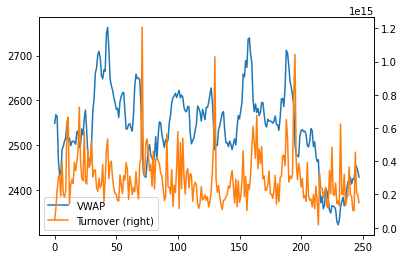

In [ ]:
tcs[[ 'VWAP', 'Turnover']].plot(secondary_y='Turnover')

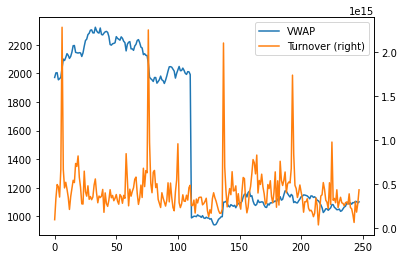

In [ ]:
infy_df[[ 'VWAP', 'Turnover']].plot(secondary_y='Turnover')

In [ ]:
drop_col = ['Symbol', 'Series', 'Prev Close', 'Last','VWAP', 'Turnover', 'Trades', 'Deliverable Volume','%Deliverble']
tcs.drop(labels = drop_col, axis = 1, inplace = True)
tcs.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-01,2567.0,2567.00,2541.00,2545.55,183415
1,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870
2,2015-01-05,2581.0,2599.90,2524.65,2540.25,877121
3,2015-01-06,2529.1,2529.10,2440.00,2446.60,1211892
4,2015-01-07,2470.0,2479.15,2407.45,2417.70,1318166


In [ ]:
infy_df.drop(labels = drop_col, axis = 1, inplace = True)
infy_df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-01,1968.95,1982.00,1956.9,1974.40,500691
1,2015-01-02,1972.00,2019.05,1972.0,2013.20,1694580
2,2015-01-05,2009.90,2030.00,1977.5,1995.90,2484256
3,2015-01-06,1980.00,1985.00,1934.1,1954.20,2416829
4,2015-01-07,1965.00,1974.75,1950.0,1963.55,1812479


#Part 1: Rolling window analysis of time series

In [ ]:
#Rolling window analysis of time series
#Moving Average Technical Analysis
#Grouping the data week by week by taking its average.So there will be total 52 rows in the final list
infy_df.index = pd.to_datetime(infy_df.Date)
tcs.index=pd.to_datetime(tcs.Date)
infy_week = infy_df.groupby(pd.Grouper(freq='W'))['Close'].mean()
tcs_week = tcs.groupby(pd.Grouper(freq='W'))['Close'].mean()
columns = ['04 Week MA','16 Week MA','28 Week MA','40 Week MA','52 Week MA']

#1.1 Create 4,16,....,52 week moving average (closing price) for each stock and index. This should happen through a function.

In [ ]:
#Function to create 4,16,...,52 week moving average and returning it as a list

def week_ma(data):
    week_list = [4,16,28,40,52]
    rol = []
    for i in week_list:
        rol_mean = data.rolling(window = i, min_periods = 1).mean()
        rol.append(rol_mean)
    return rol

#1.2 Create rolling window of size 10 on each stock/index. Handle unequal time series due to stock market holidays. You should look to increase your rolling window size to 50 and see how the data looks like.

In [ ]:
#Calling the function and save the output as a list
#Created a new dataframe with moving averages in respective number of weeks as window size.

week_rol = week_ma(infy_week)
infy_week_ma_df = pd.DataFrame({columns[0]:week_rol[0],columns[1]:week_rol[1],
                                columns[2]:week_rol[2],columns[3]:week_rol[3],columns[4]:week_rol[4]})
infy_week_ma_df.head()

,04 Week MA,16 Week MA,28 Week MA,40 Week MA,52 Week MA
Date,,,,,
2015-01-04,1993.800000,1993.8000,1993.8000,1993.8000,1993.8000
2015-01-11,1993.055000,1993.0550,1993.0550,1993.0550,1993.0550
2015-01-18,2034.440000,2034.4400,2034.4400,2034.4400,2034.4400
2015-01-25,2066.235000,2066.2350,2066.2350,2066.2350,2066.2350
2015-02-01,2103.313125,2081.4105,2081.4105,2081.4105,2081.4105


In [ ]:
week_rol = week_ma(tcs_week)
infy_week_ma_df = pd.DataFrame({columns[0]:week_rol[0],columns[1]:week_rol[1],
                                columns[2]:week_rol[2],columns[3]:week_rol[3],columns[4]:week_rol[4]})
infy_week_ma_df.head()

,04 Week MA,16 Week MA,28 Week MA,40 Week MA,52 Week MA
Date,,,,,
2015-01-04,2562.500000,2562.500000,2562.500000,2562.500000,2562.500000
2015-01-11,2517.315000,2517.315000,2517.315000,2517.315000,2517.315000
2015-01-18,2518.263333,2518.263333,2518.263333,2518.263333,2518.263333
2015-01-25,2515.817500,2515.817500,2515.817500,2515.817500,2515.817500
2015-02-01,2504.464375,2516.071500,2516.071500,2516.071500,2516.071500


In [ ]:
#Creating a new dataframe on daily basis with missing values (that of stock market holidays) are filled with 
#that of the previous working day.

infy_day = infy_df.asfreq('D', method ='ffill')
tcs_day = tcs.asfreq('D', method ='ffill')

In [ ]:
#Function to create 10,25,50,75 days moving average and returning it as a list

columns_day = ['10 Day MA','25 Day MA','50 Day MA','75 Day MA']
def day_ma(data):
    day_list = [10,25,50,75]
    rol = []
    for i in day_list:
        rol_mean = data.rolling(window = i, min_periods = 1).mean()
        rol.append(rol_mean)
    return rol

In [ ]:
#Calling the function and save the output as a list
#Created a new dataframe with moving averages in respective number of days as window size.

day_rol = day_ma(infy_day['Close'])
infy_day_ma_df = pd.DataFrame({columns_day[0]:day_rol[0],columns_day[1]:day_rol[1],
                                columns_day[2]:day_rol[2],columns_day[3]:day_rol[3]})
infy_day_ma_df.head()

,10 Day MA,25 Day MA,50 Day MA,75 Day MA
Date,,,,
2015-01-01,1974.400000,1974.400000,1974.400000,1974.400000
2015-01-02,1993.800000,1993.800000,1993.800000,1993.800000
2015-01-03,2000.266667,2000.266667,2000.266667,2000.266667
2015-01-04,2003.500000,2003.500000,2003.500000,2003.500000
2015-01-05,2001.980000,2001.980000,2001.980000,2001.980000


In [ ]:
day_rol = day_ma(tcs_day['Close'])
tcs_day_ma_df = pd.DataFrame({columns_day[0]:day_rol[0],columns_day[1]:day_rol[1],
                                columns_day[2]:day_rol[2],columns_day[3]:day_rol[3]})
tcs_day_ma_df.head()


,10 Day MA,25 Day MA,50 Day MA,75 Day MA
Date,,,,
2015-01-01,2545.550,2545.550,2545.550,2545.550
2015-01-02,2562.500,2562.500,2562.500,2562.500
2015-01-03,2568.150,2568.150,2568.150,2568.150
2015-01-04,2570.975,2570.975,2570.975,2570.975
2015-01-05,2564.830,2564.830,2564.830,2564.830


#Create the following dummy time series:

#3.1 Volume shocks : 

In [ ]:
#If volume traded is 10% higher/lower than previous day - make a 0/1 boolean time series for shock,
#data['vol_shock_direction'] only takes the difference between the consecutive rows

def volume_shocks(data):
    
    data['10_pct_vol_shock'] = (abs( data['Volume'].pct_change()*100)  >= 10).astype(int)
    data['vol_shock_direction'] = data['Volume'].diff()
    
#0/1 dummy-coded time series for direction of shock.
#data['vol_shock_direction'] will be passed as argument.
    
def vol_dir(vol):
    if(vol > 0):
        return 1
    elif(vol < 0):
        return 0
    else:
        return 'NaN'

In [ ]:
volume_shocks(infy_day)
infy_day['vol_shock_direction'] = infy_day['vol_shock_direction'].apply(vol_dir)
infy_day.head()

,Date,Open,High,Low,Close,Volume,10d,240d,10_pct_vol_shock,vol_shock_direction
Date,,,,,,,,,,
2015-01-01,2015-01-01,1968.95,1982.00,1956.9,1974.4,500691,NaN,NaN,0,NaN
2015-01-02,2015-01-02,1972.00,2019.05,1972.0,2013.2,1694580,NaN,NaN,1,1
2015-01-03,2015-01-02,1972.00,2019.05,1972.0,2013.2,1694580,NaN,NaN,0,NaN
2015-01-04,2015-01-02,1972.00,2019.05,1972.0,2013.2,1694580,NaN,NaN,0,NaN
2015-01-05,2015-01-05,2009.90,2030.00,1977.5,1995.9,2484256,NaN,NaN,1,1


In [ ]:
volume_shocks(tcs_day)
tcs_day['vol_shock_direction'] = tcs_day['vol_shock_direction'].apply(vol_dir)
tcs_day.head()

,Date,Open,High,Low,Close,Volume,10d,240d,10_pct_vol_shock,vol_shock_direction
Date,,,,,,,,,,
2015-01-01,2015-01-01,2567.0,2567.00,2541.00,2545.55,183415,NaN,NaN,0,NaN
2015-01-02,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,1,1
2015-01-03,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,0,NaN
2015-01-04,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,0,NaN
2015-01-05,2015-01-05,2581.0,2599.90,2524.65,2540.25,877121,NaN,NaN,1,1


#3.2 Price shocks:

In [ ]:

#If closing price at T vs T+1 has a difference > 2%, then 0/1 boolean time series for shock,
#data['price_shock_direction'] only takes the difference between the consecutive rows

def price_shocks(data):
    
    data['2_pct_price_shock'] = (abs( data['Close'].pct_change()*100)  > 2).astype(int)
    data['price_shock_direction'] = data['Close'].diff()


#data['price_shock_direction'] will be passed as argument.
#0/1 dummy-coded time series for direction of shock.    
    
def price_dir(price):
    if(price > 0):
        return 1
    elif(price < 0):
        return 0
    else:
        return 'NaN'

In [ ]:
#Calling the functions one by one to get the final output.

price_shocks(infy_day)
infy_day['price_shock_direction'] = infy_day['price_shock_direction'].apply(price_dir)
infy_day.head()

,Date,Open,High,Low,Close,Volume,10d,240d,10_pct_vol_shock,vol_shock_direction,2_pct_price_shock,price_shock_direction
Date,,,,,,,,,,,,
2015-01-01,2015-01-01,1968.95,1982.00,1956.9,1974.4,500691,NaN,NaN,0,NaN,0,NaN
2015-01-02,2015-01-02,1972.00,2019.05,1972.0,2013.2,1694580,NaN,NaN,1,1,0,1
2015-01-03,2015-01-02,1972.00,2019.05,1972.0,2013.2,1694580,NaN,NaN,0,NaN,0,NaN
2015-01-04,2015-01-02,1972.00,2019.05,1972.0,2013.2,1694580,NaN,NaN,0,NaN,0,NaN
2015-01-05,2015-01-05,2009.90,2030.00,1977.5,1995.9,2484256,NaN,NaN,1,1,0,0


In [ ]:
price_shocks(tcs_day)
tcs_day['price_shock_direction'] = tcs_day['price_shock_direction'].apply(price_dir)
tcs_day.head()

,Date,Open,High,Low,Close,Volume,10d,240d,10_pct_vol_shock,vol_shock_direction,2_pct_price_shock,price_shock_direction
Date,,,,,,,,,,,,
2015-01-01,2015-01-01,2567.0,2567.00,2541.00,2545.55,183415,NaN,NaN,0,NaN,0,NaN
2015-01-02,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,1,1,0,1
2015-01-03,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,0,NaN,0,NaN
2015-01-04,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,0,NaN,0,NaN
2015-01-05,2015-01-05,2581.0,2599.90,2524.65,2540.25,877121,NaN,NaN,1,1,0,0


#3.3 Pricing black swan :

In [ ]:
#As per the definition,price black swan and price shocks and their respective directions are same.
#Therefore replicating the two columns of price shock and its direction under new names as black swan and its direction.

def black_swan(data):
    data['price_black_swan'] = data['2_pct_price_shock']
    data['black_swan_dir'] = data['price_shock_direction']

#Calling the function with each datasets

black_swan(infy_day)
black_swan(tcs_day)

#3.4 Pricing shock without volume shock : 

In [ ]:

#To calculate the the price without volume shocks, 
#we need to take the logical AND of price shock and the negated volume shocks

def price_wo_vol(data):
    data['PriceShock_w/o_VolShock'] = data['2_pct_price_shock'] & (~(data['10_pct_vol_shock'].astype(bool))).astype(int)


#Calling the function with each datasets

price_wo_vol(infy_day)
price_wo_vol(tcs_day)

In [ ]:
infy_day.head(10)

,Date,Open,High,Low,Close,Volume,10d,240d,10_pct_vol_shock,vol_shock_direction,2_pct_price_shock,price_shock_direction,price_black_swan,black_swan_dir,PriceShock_w/o_VolShock
Date,,,,,,,,,,,,,,,
2015-01-01,2015-01-01,1968.95,1982.00,1956.90,1974.40,500691,NaN,NaN,0,NaN,0,NaN,0,NaN,0
2015-01-02,2015-01-02,1972.00,2019.05,1972.00,2013.20,1694580,NaN,NaN,1,1,0,1,0,1,0
2015-01-03,2015-01-02,1972.00,2019.05,1972.00,2013.20,1694580,NaN,NaN,0,NaN,0,NaN,0,NaN,0
2015-01-04,2015-01-02,1972.00,2019.05,1972.00,2013.20,1694580,NaN,NaN,0,NaN,0,NaN,0,NaN,0
2015-01-05,2015-01-05,2009.90,2030.00,1977.50,1995.90,2484256,NaN,NaN,1,1,0,0,0,0,0
2015-01-06,2015-01-06,1980.00,1985.00,1934.10,1954.20,2416829,NaN,NaN,0,0,1,0,1,0,1
2015-01-07,2015-01-07,1965.00,1974.75,1950.00,1963.55,1812479,NaN,NaN,1,0,0,1,0,1,0
2015-01-08,2015-01-08,1985.60,1997.00,1950.00,1973.45,3391230,NaN,NaN,1,1,0,1,0,1,0
2015-01-09,2015-01-09,1980.10,2109.00,1913.05,2074.45,11215832,NaN,NaN,1,1,1,1,1,1,0


In [ ]:
tcs_day.head(10)

,Date,Open,High,Low,Close,Volume,10d,240d,10_pct_vol_shock,vol_shock_direction,2_pct_price_shock,price_shock_direction,price_black_swan,black_swan_dir,PriceShock_w/o_VolShock
Date,,,,,,,,,,,,,,,
2015-01-01,2015-01-01,2567.0,2567.00,2541.00,2545.55,183415,NaN,NaN,0,NaN,0,NaN,0,NaN,0
2015-01-02,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,1,1,0,1,0,1,0
2015-01-03,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,0,NaN,0,NaN,0,NaN,0
2015-01-04,2015-01-02,2551.0,2590.95,2550.60,2579.45,462870,NaN,NaN,0,NaN,0,NaN,0,NaN,0
2015-01-05,2015-01-05,2581.0,2599.90,2524.65,2540.25,877121,NaN,NaN,1,1,0,0,0,0,0
2015-01-06,2015-01-06,2529.1,2529.10,2440.00,2446.60,1211892,NaN,NaN,1,1,1,0,1,0,0
2015-01-07,2015-01-07,2470.0,2479.15,2407.45,2417.70,1318166,NaN,NaN,0,1,0,0,0,0,0
2015-01-08,2015-01-08,2442.4,2449.00,2420.55,2443.80,782704,NaN,NaN,1,0,0,1,0,1,0
2015-01-09,2015-01-09,2455.0,2519.90,2450.00,2512.30,1598821,NaN,NaN,1,1,1,1,1,1,0


#Part 2 (data visualization ):

In [ ]:
infy_day.rename({'Close**':'Close'},axis='columns',inplace=True)

In [ ]:
import pandas as pd
import statsmodels.api as sm

#infity

In [ ]:
import altair as alt
alt.Chart(infy_day).mark_line().transform_fold(['Close']).encode(
    x='Date:T',
    y='value:Q',
    color='key:N'
)

alt.Chart(...)

In [ ]:

alt.Chart(infy_day).mark_line().transform_fold([ 'Volume','Close']).encode(
    x='Date:T',
    y='value:Q',
    color='key:N'
) 

alt.Chart(...)

#TCS

In [ ]:
import altair as alt
alt.Chart(tcs_day).mark_line().transform_fold(['Close']).encode(
    x='Date:T',
    y='value:Q',
    color='key:N'
)

alt.Chart(...)

In [ ]:
alt.Chart(infy_day).mark_line().transform_fold([ 'Volume','Close']).encode(
    x='Date:T',
    y='value:Q',
    color='key:N'
) 

alt.Chart(...)

#Model selection
#Let's build ACF and PACF for our time serie

#infity

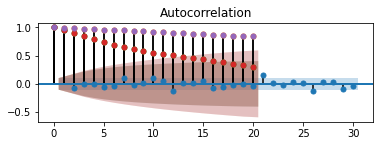

In [ ]:

sm.graphics.tsa.plot_acf(infy_day.Close.values.squeeze(), 
                         lags=20, ax=ax)

#Checking for the Autocorrelation with ACF plot 


In [ ]:

sm.graphics.tsa.plot_pacf(infy_day.Close
                          .values.squeeze(), 
                          lags=30, ax=ax);#we set Q=1

#TCS

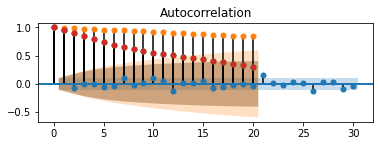

In [ ]:

sm.graphics.tsa.plot_acf(tcs_day.Close.values.squeeze(), 
                         lags=20, ax=ax)

In [ ]:
sm.graphics.tsa.plot_pacf(tcs_day.Close
                          .values.squeeze(), 
                          lags=30, ax=ax);#we set Q=1

#Part 3 (machine learning)

#Use xgboost and gridsearchcv to build a model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

#infy

In [ ]:
import numpy as np
import xgboost
x = infy_day['Close']
X_train = []
y_train = []
for i in range(60, 335):
    X_train.append(x[i-60:i])
    y_train.append(x[i])
X_train,Y_train = np.array(X_train),np.array(y_train)
cv_method = KFold(n_splits=4, shuffle=True)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
param = [{'max_depth':[1,2,3],'n_estimators':[5,10,25,50],'learning_rate':np.linspace(1e-16,1,3)}]
grid = GridSearchCV(estimator = xgb,
                               param_grid = param,
                               scoring = 'neg_mean_squared_error',
                               cv = cv_method,
                               n_jobs = -1)
grid.fit(X_train,y_train)
results=pd.DataFrame(grid.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
params_2nd_best = results.loc[1, 'params']
clf_2nd_best = grid.best_estimator_.set_params(**params_2nd_best)
print(grid.best_estimator_)
print(grid.scorer_)
grid.best_params_, grid.best_score_


#Preparing Data for predicting the Closing Values for the Last 30 Days of 2015
x = infy_day['Close'][len(infy_day['Close'])-90:]
X_test = []
for i in range(60, 90):
    X_test.append(x[i-60:i])

X_test = np.array(X_test)
Y_test = infy_day['Close'][335:]
    
y_pred = grid.predict(X_test)
        
     #Prepare the data for predicting the Close Value on 1st jan 2016
    
Jan_x = infy_day['Close'][len(infy_day['Close'])-60:]
Jan_X_test = []
Jan_X_test.append(Jan_x[0:])
Jan_X_test=np.array(Jan_X_test)
 
Jan_pred = grid.predict(Jan_X_test)
print(Jan_pred)
p = figure(plot_width=900, plot_height=500, toolbar_location="above", x_axis_type='datetime',
              title = 'XGB Model INFY')

r0 = p.line(x = Y_test.index, y = Y_test.values, color='blue')

r1 = p.line(x = Y_test.index, y = y_pred, color='red')
    
r2 = p.circle(x = date(2016,1,1), y = Jan_pred, size=10, fill_color="green", line_width = 3)
    
legend  = Legend(items=[('Actual Values of last 30 Days', [r0]),
                            ('Predicted Values of last 30 Days' , [r1]),
                           ('First January 2016 Close Value Prediction',[r2])],location=(0, -30))
    
p.add_layout(legend, 'right')

show(p)

[09:53:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=1e-16, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)
make_scorer(mean_squared_error, greater_is_better=False)
[1093.2317]


Checking if model violate any basic assumption


In [ ]:
import seaborn as sns
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [ ]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption not satisfied')
    else:
        print('Assumption  satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


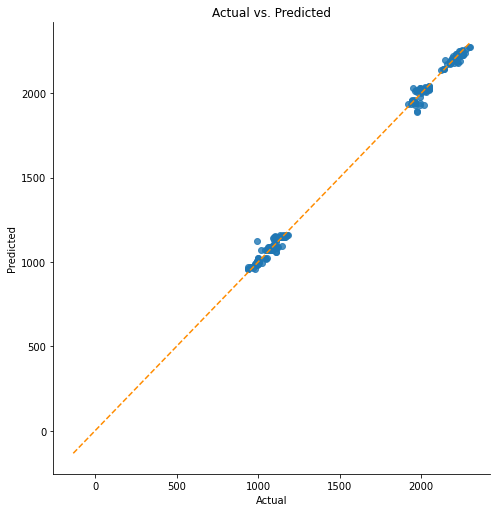

In [ ]:
linear_assumption(grid,X_train, Y_train)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 1.894901968565097e-08



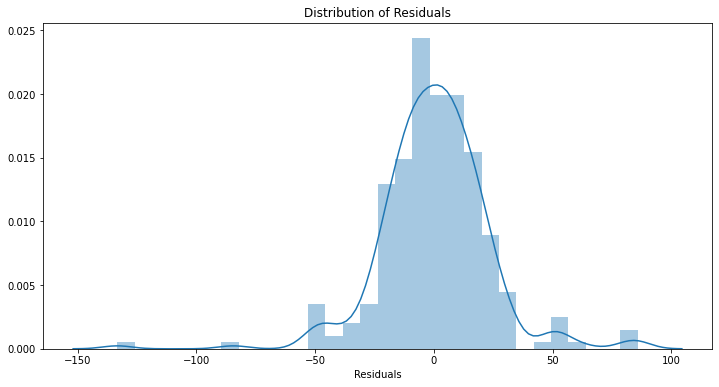


Assumption  satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [ ]:
normal_errors_assumption(grid,X_train, Y_train)

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


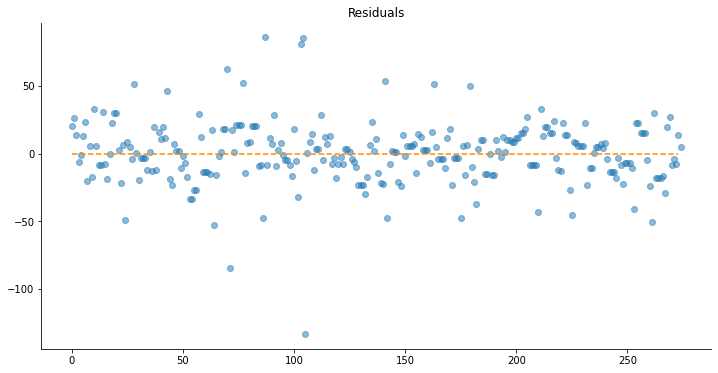

In [ ]:
homoscedasticity_assumption(grid,X_train, Y_train)

#TCS


In [ ]:
import numpy as np
import xgboost
x = tcs_day['Close']
X_train = []
y_train = []
for i in range(60, 335):
    X_train.append(x[i-60:i])
    y_train.append(x[i])
X_train,Y_train = np.array(X_train),np.array(y_train)
cv_method = KFold(n_splits=4, shuffle=True)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
param = [{'max_depth':[1,2,3],'n_estimators':[5,10,25,50],'learning_rate':np.linspace(1e-16,1,3)}]

grid1 = GridSearchCV(estimator = xgb,
                               param_grid = param,
                               scoring = 'neg_mean_squared_error',
                               cv = cv_method,
                               n_jobs = -1)
grid1.fit(X_train,y_train)
results=pd.DataFrame(grid1.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
params_2nd_best = results.loc[1, 'params']
clf_2nd_best = grid1.best_estimator_.set_params(**params_2nd_best)
print(grid1.best_estimator_)
print(grid1.scorer_)
grid1.best_params_, grid1.best_score_



#Preparing Data for predicting the Closing Values for the Last 30 Days of 2015
x = tcs_day['Close'][len(tcs_day['Close'])-90:]
X_test = []
for i in range(60, 90):
    X_test.append(x[i-60:i])

X_test = np.array(X_test)
Y_test = tcs_day['Close'][335:]
    
y_pred = grid1.predict(X_test)
        
     #Prepare the data for predicting the Close Value on 1st jan 2016
    
Jan_x = tcs_day['Close'][len(tcs_day['Close'])-60:]
Jan_X_test = []
Jan_X_test.append(Jan_x[0:])
Jan_X_test=np.array(Jan_X_test)
 
Jan_pred = grid1.predict(Jan_X_test)
print(Jan_pred)
p = figure(plot_width=900, plot_height=500, toolbar_location="above", x_axis_type='datetime',
              title = 'XGB Model TCS')

r0 = p.line(x = Y_test.index, y = Y_test.values, color='blue')

r1 = p.line(x = Y_test.index, y = y_pred, color='red')
    
r2 = p.circle(x = date(2016,1,1), y = Jan_pred, size=10, fill_color="green", line_width = 3)
    
legend  = Legend(items=[('Actual Values of last 30 Days', [r0]),
                            ('Predicted Values of last 30 Days' , [r1]),
                           ('First January 2016 Close Value Prediction',[r2])],location=(0, -30))
    
p.add_layout(legend, 'right')

show(p)

[10:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=1e-16, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)
make_scorer(mean_squared_error, greater_is_better=False)
[2396.2292]


Checking if model violate any basic assumption

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


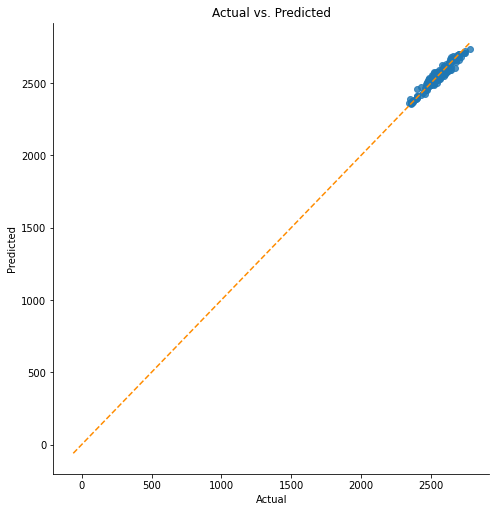

In [ ]:
linear_assumption(grid1,X_train, Y_train)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0030984765552615244



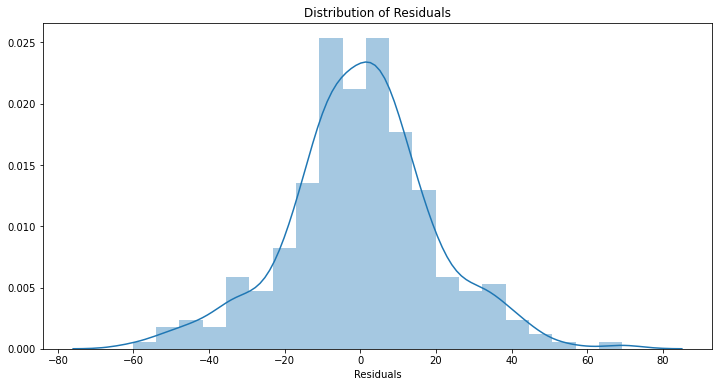


Assumption  satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [ ]:
normal_errors_assumption(grid1,X_train, Y_train)

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


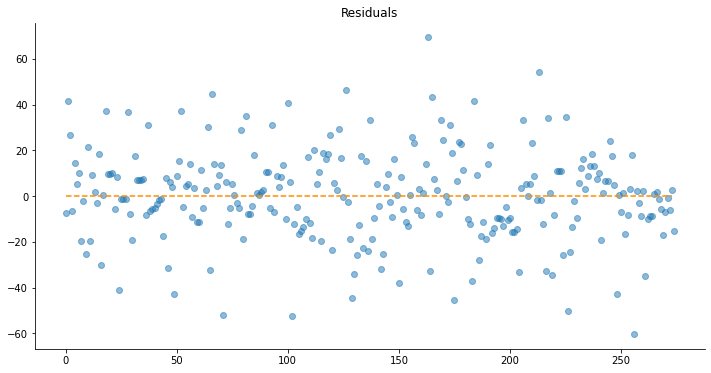

In [ ]:
homoscedasticity_assumption(grid1,X_train, Y_train)